In [2]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect= True)

In [8]:
# We can view all of the classes that automap found

Base.classes.keys()


['measurement', 'station']

In [9]:
# Save references to each table

station = Base.classes.station
measurement = Base.classes.measurement


In [10]:
# Create our session (link) from Python to the DB

session = Session(engine)


# Exploratory Climate Analysis

In [27]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database

final_data_point = session.query(measurement.date).order_by(measurement.date.desc()).first()

last_12_months = dt.date(2017, 8,23) - dt.timedelta(days= 365)



In [28]:
# Perform a query to retrieve the data and precipitation scores

precipitation = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date > last_12_months).\
    order_by(measurement.date).all()



In [29]:
# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df= pd.DataFrame(precipitation)

prcp_df.rename(columns = {0: 'date', 1: 'precipitation'}, inplace= True)



In [30]:
prcp_df.set_index('date').head()

,precipitation
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


In [14]:
# Sort the dataframe by date

prcp_df.sort_values(by=['date'])


,date,precipitation
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22
...,...,...
2218,2017-08-22,0.50
2221,2017-08-23,0.08
2219,2017-08-23,0.00
2220,2017-08-23,0.00


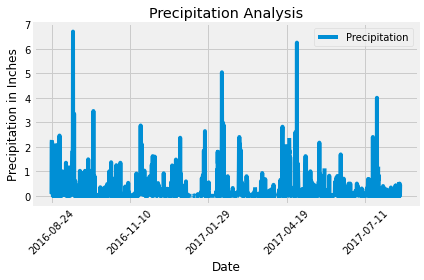

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

prcp_df.plot('date', 'precipitation')
plt.xlabel("Date")
plt.ylabel("Precipitation in Inches")
plt.title("Precipitation Analysis")
plt.legend(["Precipitation"])
plt.xticks(rotation= 45)
plt.tight_layout()
plt.savefig("Images/Precipitation Analysis")
plt.show()





In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?

stations = session.query(measurement).group_by(measurement.station).count()
print('There are {} stations available.'.format(stations))


There are 9 stations available.


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

most_active = session.query(measurement.station, func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

print(f"Most Active Stations")

most_active

Most Active Stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

station_temps = most_active[0][0]

station_temps = session.query(func.min( measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == station_temps).all()

print(f"Most Active Station Temperatures")
print(f"Low: {station_temps[0][0]} High: {station_temps[0][1]} Average: {round(station_temps[0][2], 1)}")


Most Active Station Temperatures
Low: 54.0 High: 85.0 Average: 71.7


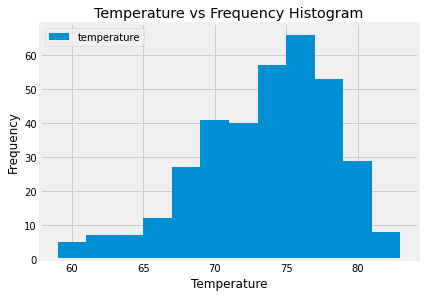

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_tempature_observations = session.query(measurement.station, func.count(measurement.tobs)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).first()
most_tempature_observations = most_tempature_observations[0]

tempature_observations = session.query(measurement.tobs).filter(measurement.date >= last_12_months).filter(measurement.station == most_tempature_observations).all()
tempature_observations = pd.DataFrame(tempature_observations, columns=['temperature'])

tempature_observations.plot.hist(bins=12, title="Temperature vs Frequency Histogram")
plt.tight_layout()
plt.xlabel("Temperature")
plt.savefig("Images/Temp vs Frequency Histogram")
plt.show()



## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [23]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [24]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation




In [25]:
Create a query that will calculate the daily normals
(i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)
def daily_normals(date): """Daily Normals.
Args:
    date (str): A date string in the format '%m-%d'

Returns:
    A list of tuples containing the daily normals, tmin, tavg, and tmax

"""

sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
daily_normals("01-01")

SyntaxError: invalid syntax (<ipython-input-25-63f075ab7ac1>, line 1)

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
